In [ ]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [22]:
#State Variable

x = np.array([0, 1., 0., 0.5]) # Initial state (px, vx, py, vy)

#Initialising covariances to zero because I'm assuming that everything is independent of each other at the start
P = np.diag([0.01, 0.1, 0.01, 0.1])  # Initial covariance matrix

dt = 1  # Time step (in seconds)

F = np.array([[1, dt, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, dt], 
              [0, 0, 0, 1]])  # Constant Velocity Model

sigma_acc = 1.0  # Standard deviation of the acceleration (m/s^2);
q = sigma_acc**2
Q = np.array([[dt**4/4, dt**3/2, 0, 0],
                [dt**3/2, dt**2, 0, 0], 
                [0, 0, dt**4/4, dt**3/2], 
                [0, 0, dt**3/2, dt**2]]) * q

H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])  # Measurement matrix (we only measure position)


Chose the position of the car to start at the origin and the car to have a velocity of ($1ms^{-1}$, $0.5ms^{-1}$), because they were simple values.

Then for my Covariance matrix I chose small values because I'm deciding that initially I'm very sure about its position and I'm very sure about its velocity just not quite as sure as I am position.

For the Process Model, F, in our constant velocity model the position is given to us by $\bar{x} = x + \dot{x} \Delta t$, where $\bar{x}$ is our state estimate, and $\dot{x}$ is the derivate of the position, i.e. the velocity. And because velocity is constant we have $\dot{x}$ = $\dot{x}$. So we have $$\bar{x}_k = 1 \cdot x_{k-1} + \Delta t\,\dot{x_{k-1}}$$ and  $$\bar{\dot{x}} = 0 \cdot x_{k - 1} + 1 \cdot \dot{x_{k-1}}$$ this gives us our matrix form. $$\begin{bmatrix} \bar{x} \\ \bar{\dot{x}} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x_{k-1} \\ \dot{x_{k-1}} \end{bmatrix}$$ $$ \bar{x} = Fx $$


Q is the noise covariance matrix, this will be our acceleration noise that the constant velocity model isn’t entirely accurate about. We know

$$x_{k+1} = x_k + v_k\Delta t + \tfrac{1}{2} a_k (\Delta t)^2$$
and
$$\dot{x}_{k+1} = \dot{x}_k + a_k \Delta t$$

We assume $a_k \sim \mathcal{N}(0, \sigma_{\text{acc}}^2)$, so the noise vector thus become
$\begin{bmatrix} \tfrac{1}{2} a_k (\Delta t)^2 \\ a_k \Delta t \end{bmatrix}$.

Multiplying by its transpose we then get
$a_k^2 \cdot \begin{bmatrix} \tfrac{1}{4} (\Delta t)^4 & \tfrac{1}{2} (\Delta t)^3 \\ \tfrac{1}{2} (\Delta t)^3 & (\Delta t)^2 \end{bmatrix}$.

Now because $a$ is a random variable, $a^2$ is also random, to make this covariance matrix useful we then take the expectation of $a^2$ which turns out to be $\sigma_{\text{acc}}^2$, which we can work out using our equation for working out the variance. Giving us the final noise covariance matrix. I'm assuming that both x velocity and y velocity have the same variance.

<!-- Need to decide how I'll choose sigma_acc -->

For H we want to be able to calculate residuals so in order to compare our estimation with our measurements I make sure to use a matrix that outputs both the x and y position.



In [3]:
#Kalman Filter Functions

def predict(x, P, F, Q):
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

def update(x_pred, P_pred, z, H, R):
    y = z - H @ x_pred  # Measurement residual
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    x_upd = x_pred + K @ y
    I = np.eye(P_pred.shape[0])
    P_upd = (I - K @ H) @ P_pred
    return x_upd, P_upd

In [17]:
#Implementation of Kalman Filter
def kalman_filter(true_states, x, P, F, Q, H, R):
    x = x.copy()
    P = P.copy()

    true_positions = []
    measurements = []
    estimates = []

    for k in range(len(true_states)):
        true_state = true_states[k]         
        true_pos = H @ true_state

        noise_std = np.sqrt(R[0,0])
        z = true_pos + np.random.normal(0, noise_std, size=2)

        x_pred, P_pred = predict(x, P, F, Q)
        x, P = update(x_pred, P_pred, z, H, R)

        true_positions.append(true_pos)
        measurements.append(z)
        estimates.append([x[0], x[2]])

    return np.array(true_positions), np.array(measurements), np.array(estimates)

In [45]:
#Plotting Function
def plot_results(true_positions, measurements, estimates):
    time_idx = np.arange(len(measurements))        # 0, 1, 2, ..., N-1

    plt.figure(figsize=(10, 6))

    # 1. True trajectory (car following constant velocity)
    plt.plot(true_positions[:, 0], true_positions[:, 1],
            label="True Position", linewidth=2)

    # 2. Measurements, colour = time step
    sc = plt.scatter(measurements[:, 0], measurements[:, 1],
                    c=time_idx,
                    cmap="viridis",      # try 'plasma' or 'inferno' if you prefer
                    s=15,
                    alpha=0.9,
                    label="Measurements")

    cbar = plt.colorbar(sc)
    cbar.set_label("Time step")

    # 3. Kalman Filter estimate
    plt.plot(estimates[:, 0], estimates[:, 1],
            label="KF Estimate", linewidth=2)

    plt.title("Kalman Filter Tracking a Constant-Velocity Car")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.autoscale()
    plt.grid(True)
    plt.legend()
    plt.show()

In [11]:
def constant_velocity_true_position(num_steps, dt, v_x, v_y):
    true_states = []

    for k in range(num_steps):
        t = k * dt
        px = v_x * t
        py = v_y * t
        true_state = np.array([px, v_x, py, v_y])
        true_states.append(true_state)

    return np.array(true_states)

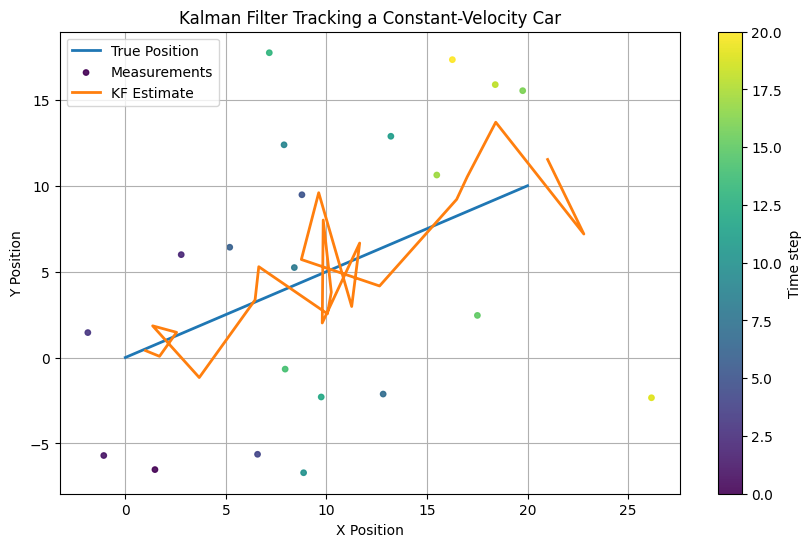

In [46]:
#Now we run and plot the results
true_states = constant_velocity_true_position(21, dt, 1.0, 0.5)

R = np.diag([25, 25])

true_positions, measurements, estimates = kalman_filter(x=x, P=P, F=F, Q=Q, H=H, R=R, true_states = true_states)

plot_results(true_positions, measurements, estimates)

Maybe too much noise for this graph as dt is only 1 second. Vx and vy are 1 and 0.5 respectively, meaning that after each time step the car moves around 1 meter in x axis and half a meter in the y axis after a time step, but my measurement noise makes my readings accurate to ±5 meters which is much larger.

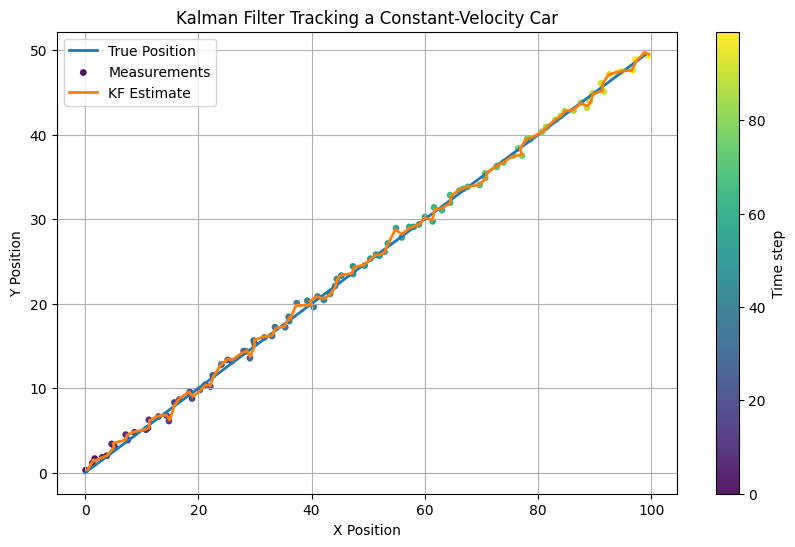

In [47]:
R = np.diag([0.25, 0.25])
true_states = constant_velocity_true_position(100, dt, 1.0, 0.5)

true_positions, measurements, estimates = kalman_filter(true_states, x, P, F, Q, H, R)

plot_results(true_positions, measurements, estimates)



That's more like it.

And for my next trick, I'll be using measurements that don't quite follow the constant velocity model that I have assumed.

In [24]:
def quadratic_true_position(num_steps, dt, v0_x, k_y):
    true_states = []

    t = 0.0
    for _ in range(num_steps):
        t += dt

        px = v0_x * t
        vx = v0_x

        py = k_y * (t ** 2)
        vy = 2 * k_y * t       

        true_states.append(np.array([px, vx, py, vy]))

    return np.array(true_states)

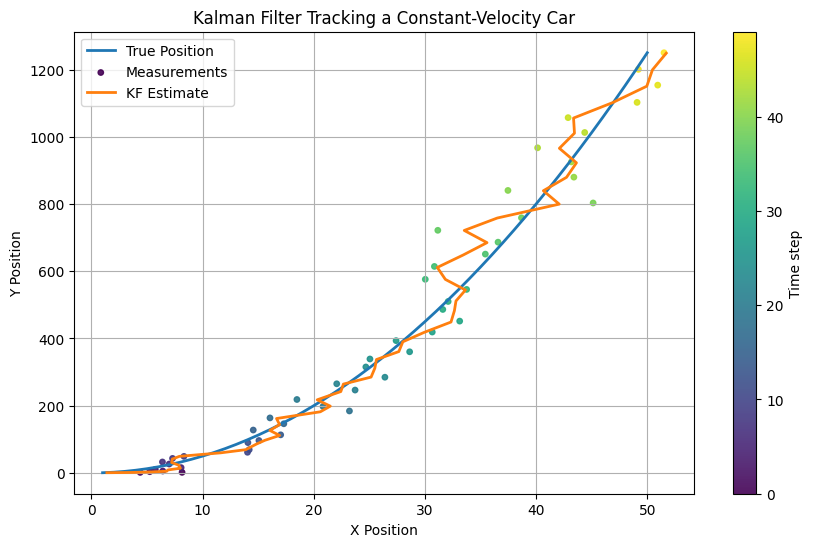

In [ ]:
R = np.diag([6.25, 6.25]) #95% of measurements within ±5m of the true data.

true_states = quadratic_true_position(50, dt, 1.0, 0.5)

true_positions, measurements, estimates = kalman_filter(true_states, x, P, F, Q, H, R)

plot_results(true_positions, measurements, estimates)
